<a href="https://colab.research.google.com/github/bruce1095/Cross-Asset-Dashbaord/blob/main/_Cross_Asset_Terminal_October2025_Improved_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

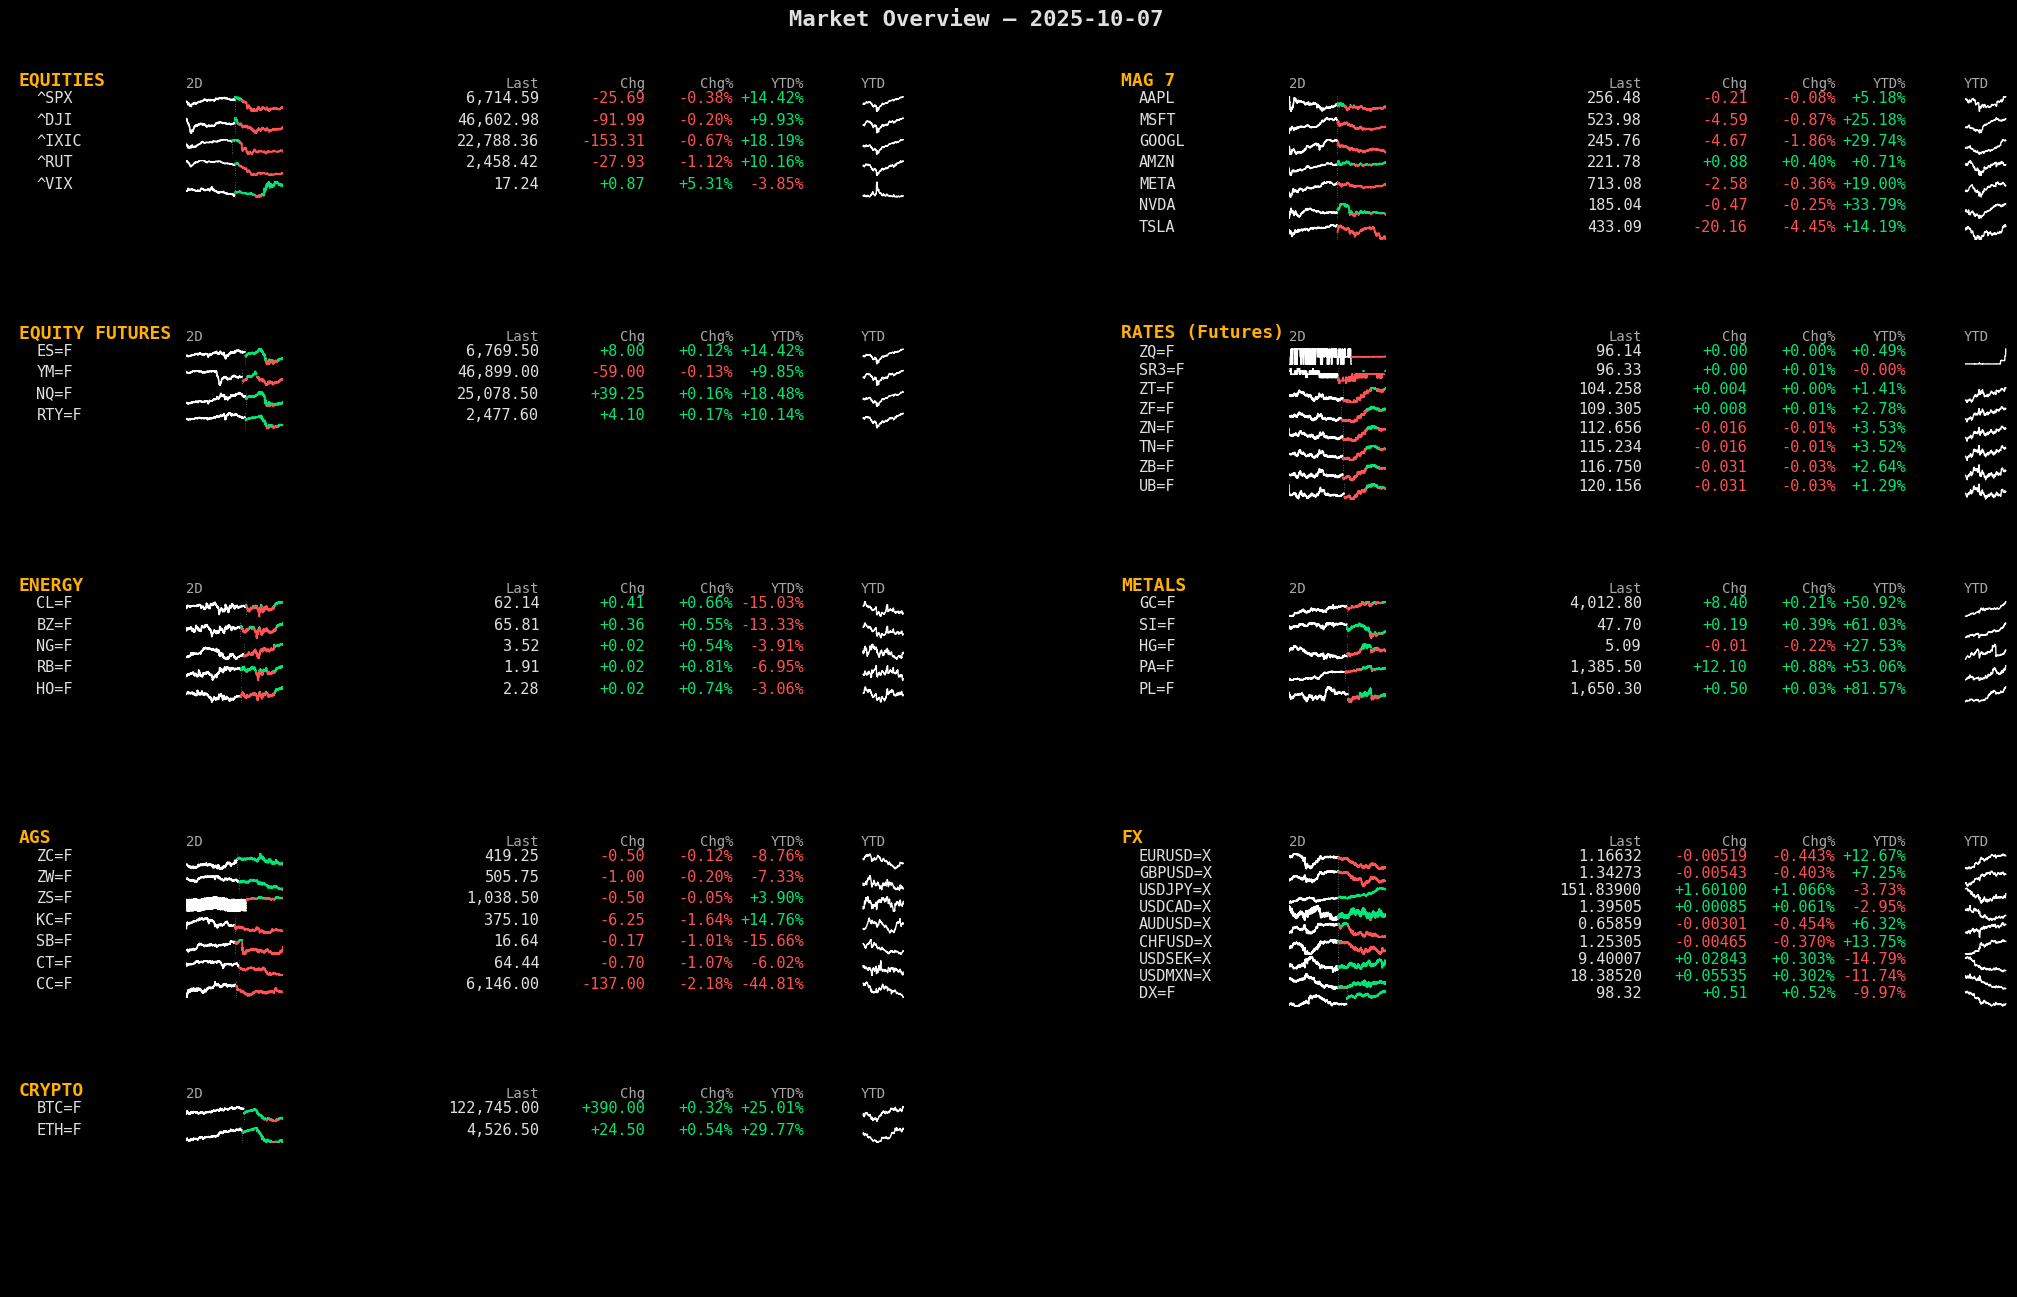

In [ ]:
###ORGINAL Version 1.0####
#!/usr/bin/env python3

# Bloomberg-style Market Overview — two-tone 2D spark (Yahoo-aligned) + single white YTD spark
# --------------------------------------------------------------------------------------------
# • Main series: 1y/1h
# • 2D spark: 5d/1m (fallback 5d/5m → upsampled to 1m), yesterday=white, today two-tone vs Yahoo prev close
# • YTD spark: white (Jan-1 → today), in its own far-right slim column
# • Sections: Equities, MAG7, Equity Futures, Rates, Energy, Metals, Ags, FX, Crypto
# • Indices & Equities use Yahoo regularMarket* fields; everything else uses robust generic Yahoo path
# • Auto 1/2/3 columns — numerics right-aligned, no overlap

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime
from zoneinfo import ZoneInfo

# ---------------- Theme ----------------
AMBER="#FFB000"; UP="#00E676"; DOWN="#FF5252"; TEXT="#E0E0E0"; SUB="#A8A8A8"; WHITE="#FFFFFF"

plt.rcParams.update({
		"figure.facecolor": "#000",
		"axes.facecolor": "#000",
		"axes.edgecolor": "#1a1a1a",
		"savefig.facecolor":"#000",
		"font.size": 11,
		"font.family": "DejaVu Sans Mono",
})

# ---------------- Universe ----------------
EQUITIES = ["^SPX","^DJI","^IXIC","^RUT","^VIX"]
MAG7     = ["AAPL","MSFT","GOOGL","AMZN","META","NVDA","TSLA"]
EQ_FUTS  = ["ES=F","YM=F","NQ=F","RTY=F"]

RATES    = ["ZQ=F","SR3=F","ZT=F","ZF=F","ZN=F","TN=F","ZB=F","UB=F"]
ENERGY   = ["CL=F","BZ=F","NG=F","RB=F","HO=F"]
METALS   = ["GC=F","SI=F","HG=F","PA=F","PL=F"]
AGS      = ["ZC=F","ZW=F","ZS=F","KC=F","SB=F","CT=F","CC=F"]

FX = ["EURUSD=X","GBPUSD=X","USDJPY=X","USDCAD=X","AUDUSD=X","CHFUSD=X","USDSEK=X","USDMXN=X","DX=F"]

# Using futures tickers for crypto per your working setup
CRYPTO = ["BTC=F","ETH=F"]

SECTIONS = [
		("EQUITIES",         EQUITIES),
		("MAG 7",            MAG7),
		("EQUITY FUTURES",   EQ_FUTS),
		("RATES (Futures)",  RATES),
		("ENERGY",           ENERGY),
		("METALS",           METALS),
		("AGS",              AGS),
		("FX",               FX),
		("CRYPTO",           CRYPTO),
]

# ---------------- Symbol classification ----------------
def is_index(sym: str) -> bool:
		return sym.startswith("^")

def is_equity(sym: str) -> bool:
		# US single names/ETFs: letters (and maybe dots), not futures/FX/crypto
		return (not is_index(sym)) and sym.replace(".","").isalpha() and not sym.endswith("=F") and not sym.endswith("=X") and not sym.endswith("-USD")

def is_fx(sym: str) -> bool:
		return sym.endswith("=X")

def is_future(sym: str) -> bool:
		return sym.endswith("=F") or ".NYM" in sym or ".CBT" in sym or ".NYB" in sym or ".CMX" in sym

def is_crypto(sym: str) -> bool:
		return sym.endswith("-USD")

# ---------------- Yahoo helpers (indices/equities exact) ----------------
def _yahoo_prevclose_index_or_equity(symbol: str) -> float | None:
		t = yf.Ticker(symbol)
		# fast_info first
		try:
				fi = t.fast_info
				if isinstance(fi, dict):
						for k in ("regularMarketPreviousClose","regular_market_previous_close","previous_close","previousClose"):
								v = fi.get(k)
								if v not in (None, 0): return float(v)
		except Exception:
				pass
		# info fallback
		try:
				info = t.info
				if isinstance(info, dict):
						for k in ("regularMarketPreviousClose","previousClose"):
								v = info.get(k)
								if v not in (None, 0): return float(v)
		except Exception:
				pass
		# daily fallback
		try:
				daily = t.history(period="30d", interval="1d")["Close"].dropna()
				if not daily.empty: return float(daily.iloc[-1])
		except Exception:
				pass
		return None

def _yahoo_last_index_or_equity_price(symbol: str) -> float | None:
		t = yf.Ticker(symbol)
		try:
				fi = t.fast_info
				if isinstance(fi, dict):
						for k in ("regularMarketPrice","regular_market_price","last_price","lastPrice"):
								v = fi.get(k)
								if v not in (None, 0): return float(v)
		except Exception:
				pass
		try:
				info = t.info
				if isinstance(info, dict):
						v = info.get("regularMarketPrice")
						if v not in (None, 0): return float(v)
		except Exception:
				pass
		return None

# ---------------- Yahoo prev-close (baseline) — generic for everything else ----------------
def yahoo_prev_close_for_symbol(symbol: str, current_et_date):
		"""
		Generic prev close resolver for futures/FX/crypto, also used as fallback.
		Order: fast_info.previous_close → info.previousClose → daily history (< ET date)
		"""
		t = yf.Ticker(symbol)
		prev = None
		# fast_info
		try:
				fi = t.fast_info
				if isinstance(fi, dict):
						for k in ("previous_close","previousClose","previousclose","regularMarketPreviousClose"):
								if k in fi and fi[k] not in (None, 0):
										prev = float(fi[k]); break
		except Exception:
				pass
		# info
		if prev is None:
				try:
						info = t.info
						if isinstance(info, dict):
								for k in ("previousClose","regularMarketPreviousClose"):
										v = info.get(k)
										if v not in (None, 0):
												prev = float(v); break
				except Exception:
						pass
		# history fallback (strictly before ET "today")
		if prev is None:
				try:
						d = t.history(period="30d", interval="1d")["Close"].dropna()
						if not d.empty:
								dates = [ts.date() for ts in d.index]
								before = d[[dt < current_et_date for dt in dates]]
								if not before.empty:
										prev = float(before.iloc[-1])
				except Exception:
						pass
		return prev

# ---------------- Yahoo last price — generic for everything else ----------------
def yahoo_last_price_for_symbol(symbol: str, intraday_series: pd.Series | None, daily_series: pd.Series | None) -> float | None:
		"""
		Resolve "last" for non-index/equity symbols (futures, FX, crypto) robustly.
		Order: fast_info regularMarketPrice/last_price → info regularMarketPrice →
						last of intraday 5d series → last daily.
		"""
		t = yf.Ticker(symbol)
		# fast_info/info
		for getter in ("fast_info","info"):
				try:
						obj = getattr(t, getter)
						if isinstance(obj, dict):
								for k in ("regularMarketPrice","regular_market_price","last_price","lastPrice"):
										v = obj.get(k)
										if v not in (None, 0):
												return float(v)
				except Exception:
						pass
		# intraday fallback
		if intraday_series is not None and not intraday_series.dropna().empty:
				try:
						return float(intraday_series.dropna().iloc[-1])
				except Exception:
						pass
		# daily fallback
		if daily_series is not None and not daily_series.dropna().empty:
				try:
						return float(daily_series.dropna().iloc[-1])
				except Exception:
						pass
		return None

# ---------------- Fetch helpers ----------------
def _flatten_close(df: pd.DataFrame) -> pd.DataFrame:
		if isinstance(df.columns, pd.MultiIndex):
				try: return df["Close"].copy()
				except Exception: return df.xs("Close", axis=1, level=-1)
		return df

def fetch_prices(tickers, period="1y", interval="1h", min_obs=20) -> pd.DataFrame:
		tks = list(dict.fromkeys([t.upper() for t in tickers]))
		raw = yf.download(tks, period=period, interval=interval,
											auto_adjust=False, progress=False, group_by="ticker")
		if raw.empty:
				raw = yf.download(tks, period="1y", interval="1d",
													auto_adjust=False, progress=False, group_by="ticker")
		df = _flatten_close(raw)
		out = pd.DataFrame(index=df.index)
		for t in tks:
				if t in df.columns:
						s = pd.to_numeric(df[t], errors="coerce").dropna()
						if s.size >= min_obs: out[t] = s
		return out.sort_index().ffill().dropna(how="all")

def _enforce_1m(series: pd.Series) -> pd.Series:
		s = series.dropna().sort_index()
		if s.empty: return s
		idx = s.index
		if idx.tz is None:
				idx = idx.tz_localize("UTC"); s.index = idx
		start, end = idx[0].ceil("T"), idx[-1].floor("T")
		if start >= end: return s
		grid = pd.date_range(start, end, freq="T", tz=idx.tz)
		return s.reindex(grid).interpolate(method="time").ffill().bfill()

def fetch_5d_minute_1m(tickers) -> dict:
		tks = list(dict.fromkeys([t.upper() for t in tickers]))
		out = {}
		d1 = _flatten_close(yf.download(tks, period="5d", interval="1m",
																		auto_adjust=False, progress=False, group_by="ticker"))
		missing = [t for t in tks if t not in getattr(d1, "columns", [])]
		d2 = _flatten_close(
				yf.download(missing, period="5d", interval="5m",
										auto_adjust=False, progress=False, group_by="ticker")
		) if missing else pd.DataFrame()
		for t in tks:
				s = None
				if t in getattr(d1, "columns", []): s = pd.to_numeric(d1[t], errors="coerce")
				elif t in getattr(d2, "columns", []): s = pd.to_numeric(d2[t], errors="coerce"); s = _enforce_1m(s)
				if s is not None and s.dropna().size > 50: out[t] = s.dropna().sort_index()
		return out

def fetch_daily(tickers, period="2y") -> pd.DataFrame:
		tks = list(dict.fromkeys([t.upper() for t in tickers]))
		raw = yf.download(tks, period=period, interval="1d",
											auto_adjust=False, progress=False, group_by="ticker")
		df = _flatten_close(raw)
		out = pd.DataFrame(index=df.index)
		for t in tks:
				if t in df.columns: out[t] = pd.to_numeric(df[t], errors="coerce")
		return out.sort_index().ffill().dropna(how="all")

# ---------------- Timezone helpers (ET date for deltas) ----------------
def to_eastern(s: pd.Series) -> pd.Series:
		idx = s.index
		if idx.tz is None:
				idx = idx.tz_localize("UTC")
		idx = idx.tz_convert(ZoneInfo("America/New_York"))
		return pd.Series(s.values, index=idx, name=s.name)

def last_two_sessions_et(s: pd.Series):
		se = to_eastern(s).dropna()
		if se.empty: return None, None, None
		dlist = pd.Series(se.index.date).unique()
		if len(dlist) < 2: return se, None, dlist[-1]
		prev_d, today_d = dlist[-2], dlist[-1]
		prev_s  = se[pd.Series(se.index.date).values == prev_d]
		today_s = se[pd.Series(se.index.date).values == today_d]
		return prev_s, today_s, today_d

def yahoo_prev_close_from_daily(daily: pd.Series, current_et_date):
		if daily is None or daily.empty: return None
		dates = pd.to_datetime(daily.index).date
		mask  = np.array(dates) < current_et_date
		if not mask.any(): return None
		return float(daily[mask].iloc[-1])

# ---------------- Formatting ----------------
def fmt_num(v, unit="", fx=False, bonds=False, chg=False):
		if pd.isna(v): return "—"
		if unit == "%": return f"{v:.2f}{unit}"
		if fx: return f"{v:.5f}" if not chg else f"{v:+.5f}"
		if bonds: return f"{v:,.3f}" if not chg else f"{v:+,.3f}"
		return f"{v:,.2f}" if not chg else f"{v:+,.2f}"

def fmt_pct(v, dp=2):
		if pd.isna(v): return "—"
		return f"{v:+.{dp}f}%"

def bonds_format_flag(ticker: str, section_is_rates: bool) -> bool:
		# 3dp for most rate futures, but NOT ZQ=F or SR3=F
		return section_is_rates and ticker.upper() not in ("ZQ=F","SR3=F")

# ---------------- Performance (unified; baseline exact = Yahoo) ----------------
def perf_vs_baseline(last_live: float, daily: pd.Series, current_et_date, symbol: str,
											intraday_5d: pd.Series | None):
		"""
		Baseline priority:
			Indices/Equities: regularMarketPreviousClose (fast_info/info) → daily < ET date → last daily
			Others (Futs/FX/Crypto/etc): generic prev-close resolver (fast_info/info → daily < ET) → last daily
		Last price:
			Indices/Equities: regularMarketPrice (fast_info/info)
			Others: generic last resolver (fast_info/info → last intraday → last daily)
		Returns: chg, chg%, ytd%, color, baseline_used, last_px
		"""
		if daily is None or daily.empty:
				return (np.nan, np.nan, np.nan, DOWN, None, np.nan)

		# LAST
		if is_index(symbol) or is_equity(symbol):
				ylast = _yahoo_last_index_or_equity_price(symbol)
				if ylast is None:
						# fallback to intraday or daily
						ylast = yahoo_last_price_for_symbol(symbol, intraday_5d, daily)
				last_px = float(ylast) if ylast is not None else float(daily.iloc[-1])
				baseline = _yahoo_prevclose_index_or_equity(symbol)
				if baseline is None:
						baseline = yahoo_prev_close_from_daily(daily, current_et_date) or float(daily.iloc[-1])
		else:
				last_px = yahoo_last_price_for_symbol(symbol, intraday_5d, daily)
				if last_px is None:
						last_px = float(daily.iloc[-1])
				baseline = yahoo_prev_close_for_symbol(symbol, current_et_date)
				if baseline is None:
						baseline = yahoo_prev_close_from_daily(daily, current_et_date) or float(daily.iloc[-1])

		# Delta calc
		chg  = last_px - baseline
		chgp = (chg / baseline) * 100.0 if baseline else np.nan
		col  = UP if chg >= 0 else DOWN

		# YTD (vs first close of year)
		d_dates = pd.to_datetime(daily.index)
		y0  = pd.Timestamp(current_et_date.year, 1, 1)
		i0  = d_dates.searchsorted(y0, side="left")
		base= daily.iloc[i0] if i0 < len(daily) else daily.iloc[0]
		ytd = (last_px/base - 1.0)*100.0

		return chg, chgp, ytd, col, float(baseline), float(last_px)

# ---------------- Sparks ----------------
def spark_2day(ax, s5d: pd.Series, daily_anchor: pd.Series|None, baseline_value: float|None):
		s = s5d.dropna()
		if len(s) < 60: ax.axis("off"); return
		dates = pd.Series(s.index.date).unique()
		if len(dates) < 2: ax.axis("off"); return

		d_prev, d_today = dates[-2], dates[-1]
		pre = s[pd.Series(s.index.date).values == d_prev]
		tod = s[pd.Series(s.index.date).values == d_today]
		if len(pre) < 5 or len(tod) < 5: ax.axis("off"); return

		comb = pd.concat([pre, tod])
		lo, hi = float(comb.min()), float(comb.max())
		pre_n = (pre - lo) / (hi - lo + 1e-12)
		tod_n = (tod - lo) / (hi - lo + 1e-12)

		base_val = baseline_value
		if base_val is None and daily_anchor is not None and not daily_anchor.empty:
				base_val = yahoo_prev_close_from_daily(daily_anchor, d_today)
		base_n = (base_val - lo) / (hi - lo + 1e-12) if base_val is not None else None

		x0 = np.arange(len(pre_n), dtype=float)
		x1 = np.arange(len(pre_n), len(pre_n) + len(tod_n), dtype=float)

		ax.set_xlim(0, len(pre_n) + len(tod_n) - 1)
		ax.set_ylim(min(pre_n.min(), tod_n.min()) - 0.02, max(pre_n.max(), tod_n.max()) + 0.02)

		# yesterday
		ax.plot(x0, pre_n.values, color=WHITE, lw=1.2, solid_capstyle="round", clip_on=True)

		# today: two-tone vs baseline if available, else single-tone vs first tick
		if base_n is None:
				up = float(tod.iloc[-1]) >= float(tod.iloc[0])
				ax.plot(x1, tod_n.values, color=(UP if up else DOWN), lw=1.4, solid_capstyle="round", clip_on=True)
		else:
				above = tod_n.values >= base_n
				seg_start = 0
				for i in range(1, len(tod_n)):
						if above[i] != above[i-1]:
								ax.plot(x1[seg_start:i], tod_n.values[seg_start:i],
												color=(UP if above[i-1] else DOWN), lw=1.4, solid_capstyle="round", clip_on=True)
								seg_start = i
				ax.plot(x1[seg_start:], tod_n.values[seg_start:], color=(UP if above[-1] else DOWN),
								lw=1.4, solid_capstyle="round", clip_on=True)

		ax.axvline(x=len(pre_n) - 1, color="#666", lw=0.7, ls=":", clip_on=True)
		ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)

# ------ replace your current spark_ytd with this one ------
def spark_ytd(ax, daily: pd.Series):
    # Show a simple white YTD spark for the calendar year of the latest point.
    if daily is None or daily.empty:
        ax.axis("off"); return

    d = daily.dropna()
    # Select only rows from the same calendar year as the last observation.
    idx = pd.DatetimeIndex(d.index)
    this_year = idx[-1].year
    dy = d[idx.year == this_year]

    if len(dy) < 5:
        ax.axis("off"); return

    y = (dy - dy.min()) / (dy.max() - dy.min() + 1e-12)
    ax.plot(np.arange(len(y)), y.values, color=WHITE, lw=1.0)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)

# ---------------- Table painter (auto 1/2/3 columns; tight anchors, no overlap) ----------------
def section_table(ax, title, live_1h: pd.DataFrame, daily_all: pd.DataFrame,
                  intraday_5d_1m: dict, is_rates=False):
    ax.set_axis_off()
    ax.text(0.01, 0.985, title, color=AMBER, fontsize=13, weight="bold", transform=ax.transAxes)

    # Wider spacing between columns; YTD spark stays far right
    XS = dict(
        tk=0.03,        # a touch more left padding for the ticker text
        spark2d=0.20,   # 2D spark box
        last=0.60,      # Last (moved right)
        chg=0.72,       # Net change
        chgp=0.82,      # % change
        ytd=0.90,       # YTD% (numeric)
        sparkYTD=0.965, # YTD spark (white, slim, far right)
    )

    HEADER_Y = 0.972   # put headers higher so they never kiss row 1 values
    TOP_Y    = 0.895    # start of first row a bit lower
    BOT_Y    = 0.10

    def headers(xoff):

        ax.text(xoff + XS['spark2d'],  HEADER_Y, "2D",     color=SUB, fontsize=10, transform=ax.transAxes)
        ax.text(xoff + XS['last'],     HEADER_Y, "Last",   color=SUB, fontsize=10, transform=ax.transAxes, ha="right")
        ax.text(xoff + XS['chg'],      HEADER_Y, "Chg",    color=SUB, fontsize=10, transform=ax.transAxes, ha="right")
        ax.text(xoff + XS['chgp'],     HEADER_Y, "Chg%",   color=SUB, fontsize=10, transform=ax.transAxes, ha="right")
        ax.text(xoff + XS['ytd'],      HEADER_Y, "YTD%",   color=SUB, fontsize=10, transform=ax.transAxes, ha="right")
        ax.text(xoff + XS['sparkYTD'], HEADER_Y, "YTD",    color=SUB, fontsize=10, transform=ax.transAxes)

    n = len(live_1h.columns)
    if n <= 12:      ncols = 1
    elif n <= 16:   ncols = 2
    else:           ncols = 3

    col_width = 1.0 / ncols
    per_col   = int(np.ceil(n / ncols))
    slices    = [live_1h.columns[i*per_col:(i+1)*per_col] for i in range(ncols)]

    available = TOP_Y - BOT_Y
    max_rows  = max((len(s) for s in slices if len(s)>0), default=1)
    row_h     = min(0.11, available / max_rows)
    y_start   = TOP_Y

    for ci, syms in enumerate(slices):
        if len(syms) == 0: continue
        xoff = ci * col_width
        headers(xoff)
        y = y_start
        for t in syms:
            s = live_1h[t].dropna()
            intr = intraday_5d_1m.get(t, None)
            d_raw = daily_all[t].dropna() if t in daily_all.columns else s.resample("1D").last()

            # Determine ET "today"
            if intr is not None and not intr.dropna().empty:
                _, today_s, _ = last_two_sessions_et(intr)
                if today_s is not None and not today_s.empty:
                    current_et_date = today_s.index[-1].date()
                else:
                    current_et_date = pd.to_datetime(d_raw.index[-1]).date() if not d_raw.empty else datetime.utcnow().date()
            else:
                current_et_date = pd.to_datetime(d_raw.index[-1]).date() if not d_raw.empty else datetime.utcnow().date()

            # Perf + exact baseline + last_px
            chg, chgp, ytd, col, baseline_used, last_px = perf_vs_baseline(
                last_live=np.nan,
                daily=d_raw, current_et_date=current_et_date, symbol=t,
                intraday_5d=intr
            )

            bonds  = bonds_format_flag(t, is_rates)
            fxflag = is_fx(t)

            # Row text (right-aligned numerics)
            ax.text(xoff + XS['tk'],   y, t, color=TEXT, fontsize=11, transform=ax.transAxes)
            ax.text(xoff + XS['last'], y, fmt_num(last_px, fx=fxflag, bonds=bonds),
                    color=TEXT, fontsize=11, transform=ax.transAxes, ha="right")
            ax.text(xoff + XS['chg'],  y, fmt_num(chg, fx=fxflag, bonds=bonds, chg=True),
                    color=col, fontsize=11, transform=ax.transAxes, ha="right")
            ax.text(xoff + XS['chgp'], y, fmt_pct(chgp, dp=(3 if fxflag else 2)),
                    color=col, fontsize=11, transform=ax.transAxes, ha="right")
            ax.text(xoff + XS['ytd'],  y, fmt_pct(ytd),
                    color=(UP if ytd>=0 else DOWN), fontsize=11, transform=ax.transAxes, ha="right")

            # 2D spark
            sp = ax.inset_axes([xoff + XS['spark2d'], y-0.046, 0.11, 0.085])  # a smidge wider too
            if intr is not None:
                spark_2day(sp, intr, d_raw, baseline_used)
            else:
                sp.axis("off")

            # YTD spark (far right)
            sp_y = ax.inset_axes([xoff + XS['sparkYTD'], y-0.046, 0.05, 0.085])
            if not d_raw.empty:
                spark_ytd(sp_y, d_raw)
            else:
                sp_y.axis("off")

            y -= row_h

# ---------------- Main ----------------
def market_overview():
		all_syms = sorted(set(sum([t for _, t in SECTIONS], [])))
		# Historical series for visuals:
		live_1h       = fetch_prices(all_syms, period="1y", interval="1h")
		daily_all     = fetch_daily(all_syms, period="2y")
		intraday_5d_1m= fetch_5d_minute_1m(all_syms)

		fig = plt.figure(figsize=(21, 14))
		# Slightly wider right margin so far-right YTD spark never clips
		gs = GridSpec(5, 2, figure=fig, left=0.04, right=0.985, bottom=0.06, top=0.92,
									hspace=0.30, wspace=0.25)

		fig.text(0.5, 0.965,
							f"Market Overview — {datetime.now().strftime('%Y-%m-%d')}",
							ha="center", va="center", color=TEXT, fontsize=16, weight="bold")

		for i, (name, tickers) in enumerate(SECTIONS):
				r, c = divmod(i, 2)
				ax = fig.add_subplot(gs[r, c])
				use = [t for t in tickers if t in live_1h.columns]
				if not use:
						ax.axis("off")
						ax.text(0.02, 0.8, f"{name} — no data", color=SUB, transform=ax.transAxes)
						continue
				section_table(ax, name, live_1h[use], daily_all, intraday_5d_1m, is_rates=("RATES" in name))
		plt.show()

if __name__ == "__main__":
		market_overview()

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#Fixed for Sunday/Monday Future Session & updated futures hours
#Improvements and Fixes--Version 1.1#####

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

# ---------------- Theme ----------------
AMBER="#FFB000"; UP="#00E676"; DOWN="#FF5252"; TEXT="#E0E0E0"; SUB="#A8A8A8"; WHITE="#FFFFFF"

plt.rcParams.update({
    "figure.facecolor": "#000",
    "axes.facecolor":   "#000",
    "axes.edgecolor":   "#1a1a1a",
    "savefig.facecolor":"#000",
    "font.size":        11,
    "font.family":      "DejaVu Sans Mono",
})

# ---------------- Universe (front-month continuous where possible) ----------------
EQUITIES = ["^SPX","^DJI","^IXIC","^RUT","^VIX","^GSPTSE","^MXX","^BVSP","^MERV","^STOXX50E","000300.SS"]
MAG7     = ["AAPL","MSFT","GOOGL","AMZN","META","NVDA","TSLA"]
EQ_FUTS  = ["ES=F","YM=F","NQ=F","RTY=F","NKD=F","MME=F"]

RATES    = ["^IRX","^FVX","^TNX","^TYX","ZQ=F","SR3=F","ZT=F","ZF=F","ZN=F","ZB=F","UB=F"]
ENERGY   = ["CL=F","BZ=F","NG=F","RB=F","HO=F","TTF=F"]
METALS   = ["GC=F","SI=F","HG=F","PA=F","PL=F","ALI=F"]      # <-- Added ALI=F
AGS      = ["ZC=F","ZW=F","ZS=F","KC=F","SB=F","CT=F","CC=F"]
FX       = ["EURUSD=X","GBPUSD=X","USDJPY=X","CADUSD=X","AUDUSD=X","USDSEK=X","CHFUSD=X","USDMXN=X","NZDUSD=X","DX=F"]
CRYPTO   = ["BTC=F","ETH=F","BTC-USD","ETH-USD","BNB-USD","XRP-USD","SOL-USD"]

SECTIONS = [
    ("EQUITIES",         EQUITIES),
    ("MAG 7",            MAG7),
    ("EQUITY FUTURES",   EQ_FUTS),
    ("RATES (Futures)",  RATES),
    ("ENERGY",           ENERGY),
    ("METALS",           METALS),
    ("AGS",              AGS),
    ("FX",               FX),
    ("CRYPTO",           CRYPTO),
]

# ---------------- Helpers: type detection ----------------
def is_index(sym: str) -> bool: return sym.startswith("^")
def is_fx(sym: str) -> bool:    return sym.endswith("=X")
def is_future(sym: str) -> bool:return sym.endswith("=F")
def is_equity(sym: str) -> bool:
    return (not is_index(sym)) and (not is_future(sym)) and (not is_fx(sym)) and sym.replace(".","").isalpha()

# ---------------- Yahoo prev/last (indices/equities) ----------------
def _yahoo_prevclose_index_or_equity(symbol: str) -> float | None:
    t = yf.Ticker(symbol)
    try:
        fi = t.fast_info
        if isinstance(fi, dict):
            for k in ("regularMarketPreviousClose","regular_market_previous_close","previous_close","previousClose"):
                v = fi.get(k)
                if v not in (None, 0): return float(v)
    except Exception: pass
    try:
        info = t.info
        if isinstance(info, dict):
            for k in ("regularMarketPreviousClose","previousClose"):
                v = info.get(k)
                if v not in (None, 0): return float(v)
    except Exception: pass
    try:
        daily = t.history(period="30d", interval="1d")["Close"].dropna()
        if not daily.empty: return float(daily.iloc[-1])
    except Exception: pass
    return None

def _yahoo_last_index_or_equity_price(symbol: str) -> float | None:
    t = yf.Ticker(symbol)
    try:
        fi = t.fast_info
        if isinstance(fi, dict):
            for k in ("regularMarketPrice","regular_market_price","last_price","lastPrice"):
                v = fi.get(k)
                if v not in (None, 0): return float(v)
    except Exception: pass
    try:
        info = t.info
        if isinstance(info, dict):
            v = info.get("regularMarketPrice")
            if v not in (None, 0): return float(v)
    except Exception: pass
    return None

# ---------------- Yahoo prev/last (generic for futs/FX/crypto) ----------------
def yahoo_prev_close_for_symbol(symbol: str, session_date):
    t = yf.Ticker(symbol)
    prev = None
    try:
        fi = t.fast_info
        if isinstance(fi, dict):
            for k in ("previous_close","previousClose","previousclose","regularMarketPreviousClose"):
                v = fi.get(k)
                if v not in (None, 0): prev = float(v); break
    except Exception: pass
    if prev is None:
        try:
            info = t.info
            if isinstance(info, dict):
                for k in ("previousClose","regularMarketPreviousClose"):
                    v = info.get(k)
                    if v not in (None, 0): prev = float(v); break
        except Exception: pass
    if prev is None:
        try:
            d = t.history(period="30d", interval="1d")["Close"].dropna()
            if not d.empty:
                dates = [ts.date() for ts in d.index]
                before = d[[dt < session_date for dt in dates]]
                if not before.empty: prev = float(before.iloc[-1])
        except Exception: pass
    return prev

def yahoo_last_price_for_symbol(symbol: str, intraday_series: pd.Series|None, daily_series: pd.Series|None) -> float | None:
    t = yf.Ticker(symbol)
    for getter in ("fast_info","info"):
        try:
            obj = getattr(t, getter)
            if isinstance(obj, dict):
                for k in ("regularMarketPrice","regular_market_price","last_price","lastPrice"):
                    v = obj.get(k)
                    if v not in (None, 0): return float(v)
        except Exception: pass
    if intraday_series is not None and not intraday_series.dropna().empty:
        try: return float(intraday_series.dropna().iloc[-1])
        except Exception: pass
    if daily_series is not None and not daily_series.dropna().empty:
        try: return float(daily_series.dropna().iloc[-1])
        except Exception: pass
    return None

# ---------------- Fetchers (robust; retry missing one-by-one) ----------------
def _flatten_close(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.columns, pd.MultiIndex):
        try: return df["Close"].copy()
        except Exception: return df.xs("Close", axis=1, level=-1)
    return df

def fetch_prices(tickers, period="1y", interval="1h", min_obs=20) -> pd.DataFrame:
    tks = list(dict.fromkeys([t.upper() for t in tickers]))
    raw = yf.download(tks, period=period, interval=interval,
                      auto_adjust=False, progress=False, group_by="ticker")
    df = _flatten_close(raw)
    out = pd.DataFrame(index=df.index)

    for t in tks:
        if t in getattr(df, "columns", []):
            s = pd.to_numeric(df[t], errors="coerce").dropna()
            if s.size >= min_obs: out[t] = s

    missing = [t for t in tks if t not in out.columns]
    for t in missing:
        try:
            r = yf.download(t, period=period, interval=interval,
                            auto_adjust=False, progress=False, group_by="ticker")
            s = _flatten_close(r)
            if t in getattr(s, "columns", []):
                col = pd.to_numeric(s[t], errors="coerce").dropna()
                if col.size >= min_obs:
                    out = out.reindex(out.index.union(col.index)).sort_index()
                    out[t] = col
                    continue
        except Exception: pass
        try:
            r = yf.download(t, period="1y", interval="1d",
                            auto_adjust=False, progress=False, group_by="ticker")
            s = _flatten_close(r)
            if t in getattr(s, "columns", []):
                col = pd.to_numeric(s[t], errors="coerce").dropna()
                out = out.reindex(out.index.union(col.index)).sort_index()
                out[t] = col
        except Exception: pass
    return out.sort_index().ffill().dropna(how="all")

def _enforce_1m(series: pd.Series) -> pd.Series:
    s = series.dropna().sort_index()
    if s.empty: return s
    idx = s.index
    if idx.tz is None:
        idx = idx.tz_localize("UTC"); s.index = idx
    start, end = idx[0].ceil("min"), idx[-1].floor("min")
    if start >= end: return s
    grid = pd.date_range(start, end, freq="min", tz=idx.tz)
    return s.reindex(grid).interpolate(method="time").ffill().bfill()

def fetch_5d_minute_1m(tickers) -> dict:
    tks = list(dict.fromkeys([t.upper() for t in tickers]))
    out = {}
    bulk = _flatten_close(yf.download(tks, period="5d", interval="1m",
                                      auto_adjust=False, progress=False, group_by="ticker"))
    for t in tks:
        if t in getattr(bulk, "columns", []):
            s = pd.to_numeric(bulk[t], errors="coerce").dropna()
            if s.size > 50: out[t] = s.sort_index()

    for t in [x for x in tks if x not in out]:
        got = False
        try:
            r = _flatten_close(yf.download(t, period="5d", interval="1m",
                                           auto_adjust=False, progress=False, group_by="ticker"))
            if t in getattr(r, "columns", []):
                s = pd.to_numeric(r[t], errors="coerce").dropna()
                if s.size > 50:
                    out[t] = s.sort_index(); got = True
        except Exception: pass
        if not got:
            try:
                r5 = _flatten_close(yf.download(t, period="5d", interval="5m",
                                                auto_adjust=False, progress=False, group_by="ticker"))
                if t in getattr(r5, "columns", []):
                    s = pd.to_numeric(r5[t], errors="coerce").dropna()
                    if s.size > 20:
                        out[t] = _enforce_1m(s).sort_index()
            except Exception: pass
    return out

def fetch_daily(tickers, period="2y") -> pd.DataFrame:
    tks = list(dict.fromkeys([t.upper() for t in tickers]))
    raw = yf.download(tks, period=period, interval="1d",
                      auto_adjust=False, progress=False, group_by="ticker")
    df = _flatten_close(raw)
    out = pd.DataFrame(index=df.index)
    for t in tks:
        if t in df.columns: out[t] = pd.to_numeric(df[t], errors="coerce")
    return out.sort_index().ffill().dropna(how="all")

# ---------------- Time helpers ----------------
def to_eastern(s: pd.Series) -> pd.Series:
    idx = s.index
    if idx.tz is None: idx = idx.tz_localize("UTC")
    idx = idx.tz_convert(ZoneInfo("America/New_York"))
    return pd.Series(s.values, index=idx, name=s.name)

def last_two_sessions_calendar(s: pd.Series):
    se = to_eastern(s).dropna()
    if se.empty: return None, None, None
    dlist = pd.Series(se.index.date).unique()
    if len(dlist) < 2: return se, None, dlist[-1]
    prev_d, today_d = dlist[-2], dlist[-1]
    prev_s  = se[pd.Series(se.index.date).values == prev_d]
    today_s = se[pd.Series(se.index.date).values == today_d]
    return prev_s, today_s, today_d

def last_two_sessions_futures(s: pd.Series, session_start_hour=18):
    se = to_eastern(s).dropna()
    if se.empty: return None, None, None
    shifted = se.copy()
    shifted.index = shifted.index - pd.Timedelta(hours=session_start_hour)
    sess_date = pd.Series(shifted.index.date, index=shifted.index)
    unique_days = pd.Series(sess_date.values).unique()
    if len(unique_days) < 2: return se, None, unique_days[-1]
    prev_d, today_d = unique_days[-2], unique_days[-1]
    prev_mask  = (sess_date.values == prev_d)
    today_mask = (sess_date.values == today_d)
    prev_s  = se[prev_mask]
    today_s = se[today_mask]
    return prev_s, today_s, today_d

def yahoo_prev_close_from_daily(daily: pd.Series, cutoff_date):
    if daily is None or daily.empty: return None
    dates = pd.to_datetime(daily.index).date
    mask  = np.array(dates) < cutoff_date
    if not mask.any(): return None
    return float(daily[mask].iloc[-1])

# ---------------- Formatting ----------------
def fmt_num(v, unit="", fx=False, bonds=False, chg=False):
    if pd.isna(v): return "—"
    if unit == "%": return f"{v:.2f}{unit}"
    if fx: return f"{v:.5f}" if not chg else f"{v:+.5f}"
    if bonds: return f"{v:,.3f}" if not chg else f"{v:+,.3f}"
    return f"{v:,.2f}" if not chg else f"{v:+,.2f}"

def fmt_pct(v, dp=2):
    if pd.isna(v): return "—"
    return f"{v:+.{dp}f}%"

def bonds_format_flag(ticker: str, section_is_rates: bool) -> bool:
    return section_is_rates and ticker.upper() not in ("ZQ=F","SR3=F")

# ---------------- Perf calc ----------------
def perf_vs_baseline(daily: pd.Series, session_date, symbol: str, intraday_5d: pd.Series | None):
    if daily is None or daily.empty:
        return (np.nan, np.nan, np.nan, DOWN, None, np.nan)

    if is_index(symbol) or is_equity(symbol):
        ylast = _yahoo_last_index_or_equity_price(symbol)
        if ylast is None: ylast = yahoo_last_price_for_symbol(symbol, intraday_5d, daily)
        last_px = float(ylast) if ylast is not None else float(daily.iloc[-1])
        baseline = _yahoo_prevclose_index_or_equity(symbol)
        if baseline is None:
            baseline = yahoo_prev_close_from_daily(daily, session_date) or float(daily.iloc[-1])
    else:
        last_px = yahoo_last_price_for_symbol(symbol, intraday_5d, daily)
        if last_px is None: last_px = float(daily.iloc[-1])
        baseline = yahoo_prev_close_for_symbol(symbol, session_date)
        if baseline is None:
            baseline = yahoo_prev_close_from_daily(daily, session_date) or float(daily.iloc[-1])

    chg  = last_px - baseline
    chgp = (chg / baseline) * 100.0 if baseline else np.nan
    col  = UP if chg >= 0 else DOWN

    d_dates = pd.to_datetime(daily.index)
    y0  = pd.Timestamp(session_date.year, 1, 1)
    i0  = d_dates.searchsorted(y0, side="left")
    base= daily.iloc[i0] if i0 < len(daily) else daily.iloc[0]
    ytd = (last_px/base - 1.0)*100.0

    return chg, chgp, ytd, col, float(baseline), float(last_px)

# ---------------- Sparks ----------------
def spark_2day(ax, s5d: pd.Series, daily_anchor: pd.Series|None, baseline_value: float|None,
               is_fut=False):
    s = s5d.dropna()
    if len(s) < 60: ax.axis("off"); return

    if is_fut:
        pre, tod, d_today = last_two_sessions_futures(s)
    else:
        pre, tod, d_today = last_two_sessions_calendar(s)
    if pre is None or tod is None or len(pre) < 5 or len(tod) < 5:
        ax.axis("off"); return

    comb = pd.concat([pre, tod])
    lo, hi = float(comb.min()), float(comb.max())
    pre_n = (pre - lo) / (hi - lo + 1e-12)
    tod_n = (tod - lo) / (hi - lo + 1e-12)

    base_val = baseline_value
    if base_val is None and daily_anchor is not None and not daily_anchor.empty:
        base_val = yahoo_prev_close_from_daily(daily_anchor, d_today)
    base_n = (base_val - lo) / (hi - lo + 1e-12) if base_val is not None else None

    x0 = np.arange(len(pre_n), dtype=float)
    x1 = np.arange(len(pre_n), len(pre_n) + len(tod_n), dtype=float)

    ax.set_xlim(0, len(pre_n) + len(tod_n) - 1)
    ax.set_ylim(min(pre_n.min(), tod_n.min()) - 0.02, max(pre_n.max(), tod_n.max()) + 0.02)

    ax.plot(x0, pre_n.values, color=WHITE, lw=1.2, solid_capstyle="round", clip_on=True)

    if base_n is None:
        up = float(tod.iloc[-1]) >= float(tod.iloc[0])
        ax.plot(x1, tod_n.values, color=(UP if up else DOWN), lw=1.4, solid_capstyle="round", clip_on=True)
    else:
        above = tod_n.values >= base_n
        seg_start = 0
        for i in range(1, len(tod_n)):
            if above[i] != above[i-1]:
                ax.plot(x1[seg_start:i], tod_n.values[seg_start:i],
                        color=(UP if above[i-1] else DOWN), lw=1.4, solid_capstyle="round", clip_on=True)
                seg_start = i
        ax.plot(x1[seg_start:], tod_n.values[seg_start:], color=(UP if above[-1] else DOWN),
                lw=1.4, solid_capstyle="round", clip_on=True)

    ax.axvline(x=len(pre_n) - 1, color="#666", lw=0.7, ls=":", clip_on=True)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)

def spark_ytd(ax, daily: pd.Series):
    if daily is None or daily.empty: ax.axis("off"); return
    d = daily.dropna()
    end_date = pd.to_datetime(d.index[-1])
    y0 = pd.Timestamp(end_date.year, 1, 1, tz=getattr(end_date, "tz", None))
    dy = d[d.index >= y0]
    if len(dy) < 5: ax.axis("off"); return
    y = (dy - dy.min()) / (dy.max() - dy.min() + 1e-12)
    ax.plot(np.arange(len(y)), y.values, color=WHITE, lw=1.0)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)

# ---------------- Table painter (now takes 'intended' list to preserve rows) ----------------
def section_table(ax, title, intended_list, live_1h: pd.DataFrame, daily_all: pd.DataFrame,
                  intraday_5d_1m: dict, is_rates=False):
    ax.set_axis_off()
    ax.text(0.01, 0.98, title, color=AMBER, fontsize=13, weight="bold", transform=ax.transAxes)

    XS = dict(
        tk=0.03, spark2d=0.20, last=0.60, chg=0.72, chgp=0.82, ytd=0.90, sparkYTD=0.965,
    )
    HEADER_Y = 0.972
    TOP_Y, BOT_Y = 0.895, 0.10

    def headers(xoff):
        ax.text(xoff + XS['spark2d'],  HEADER_Y, "2D",     color=SUB, fontsize=10, transform=ax.transAxes)
        ax.text(xoff + XS['last'],     HEADER_Y, "Last",   color=SUB, fontsize=10, transform=ax.transAxes, ha="right")
        ax.text(xoff + XS['chg'],      HEADER_Y, "Chg",    color=SUB, fontsize=10, transform=ax.transAxes, ha="right")
        ax.text(xoff + XS['chgp'],     HEADER_Y, "Chg%",   color=SUB, fontsize=10, transform=ax.transAxes, ha="right")
        ax.text(xoff + XS['ytd'],      HEADER_Y, "YTD%",   color=SUB, fontsize=10, transform=ax.transAxes, ha="right")
        ax.text(xoff + XS['sparkYTD'], HEADER_Y, "YTD",    color=SUB, fontsize=10, transform=ax.transAxes)

    n_items = len(intended_list)
    if n_items <= 14: ncols = 1
    elif n_items <= 16: ncols = 2
    else: ncols = 3

    col_width = 1.0 / ncols
    per_col   = int(np.ceil(n_items / ncols))
    slices    = [intended_list[i*per_col:(i+1)*per_col] for i in range(ncols)]

    available = TOP_Y - BOT_Y
    row_h     = min(0.11, available / (per_col if per_col>0 else 1))

    for ci, syms in enumerate(slices):
        if not syms: continue
        xoff = ci * col_width
        headers(xoff)
        y = TOP_Y

        for t in syms:
            s    = live_1h[t] if t in live_1h.columns else pd.Series(dtype=float)
            intr = intraday_5d_1m.get(t, None)
            d_raw= daily_all[t].dropna() if t in daily_all.columns else pd.Series(dtype=float)

            # Determine session date (futures vs regular)
            if intr is not None and not intr.dropna().empty:
                if is_future(t):
                    _, today_s, today_date = last_two_sessions_futures(intr)
                else:
                    _, today_s, today_date = last_two_sessions_calendar(intr)
                if today_s is not None and not today_s.empty:
                    current_session_date = today_date
                else:
                    current_session_date = (pd.to_datetime(d_raw.index[-1]).date()
                                            if not d_raw.empty else datetime.utcnow().date())
            else:
                current_session_date = (pd.to_datetime(d_raw.index[-1]).date()
                                        if not d_raw.empty else datetime.utcnow().date())

            chg, chgp, ytd, col, baseline_used, last_px = perf_vs_baseline(
                daily=d_raw, session_date=current_session_date, symbol=t, intraday_5d=intr
            )

            bonds  = bonds_format_flag(t, is_rates)
            fxflag = is_fx(t)

            ax.text(xoff + XS['tk'],   y, t, color=TEXT, fontsize=11, transform=ax.transAxes)
            ax.text(xoff + XS['last'], y, fmt_num(last_px, fx=fxflag, bonds=bonds),
                    color=TEXT, fontsize=11, transform=ax.transAxes, ha="right")
            ax.text(xoff + XS['chg'],  y, fmt_num(chg, fx=fxflag, bonds=bonds, chg=True),
                    color=col, fontsize=11, transform=ax.transAxes, ha="right")
            ax.text(xoff + XS['chgp'], y, fmt_pct(chgp, dp=(2 if fxflag else 2)),
                    color=col, fontsize=11, transform=ax.transAxes, ha="right")
            ax.text(xoff + XS['ytd'],  y, fmt_pct(ytd),
                    color=(UP if (pd.notna(ytd) and ytd>=0) else DOWN), fontsize=11, transform=ax.transAxes, ha="right")

            sp = ax.inset_axes([xoff + XS['spark2d'], y-0.046, 0.10, 0.085])
            if intr is not None and not intr.dropna().empty:
                spark_2day(sp, intr, d_raw, baseline_used, is_fut=is_future(t))
            else:
                sp.axis("off")

            sp_y = ax.inset_axes([xoff + XS['sparkYTD'], y-0.046, 0.05, 0.085])
            if not d_raw.empty:
                spark_ytd(sp_y, d_raw)
            else:
                sp_y.axis("off")

            y -= row_h

# ---------------- Main ----------------
def market_overview():
    all_syms = sorted(set(sum([t for _, t in SECTIONS], [])))
    live_1h       = fetch_prices(all_syms, period="1y", interval="1h")
    daily_all     = fetch_daily(all_syms, period="2y")
    intraday_5d_1m= fetch_5d_minute_1m(all_syms)

    fig = plt.figure(figsize=(21, 14))
    gs = GridSpec(5, 2, figure=fig, left=0.04, right=0.985, bottom=0.06, top=0.92,
                  hspace=0.30, wspace=0.25)

    fig.text(0.5, 0.965,
             f"Market Overview — {datetime.now().strftime('%Y-%m-%d')}",
             ha="center", va="center", color=TEXT, fontsize=16, weight="bold")

    for i, (name, tickers) in enumerate(SECTIONS):
        r, c = divmod(i, 2)
        ax = fig.add_subplot(gs[r, c])

        # Subframes (safe reindex; rows render even if some series are missing)
        live_sub  = live_1h.reindex(columns=[t for t in tickers if t in live_1h.columns])
        daily_sub = daily_all.reindex(columns=[t for t in tickers if t in daily_all.columns])
        intr_sub  = {t:intraday_5d_1m[t] for t in tickers if t in intraday_5d_1m}

        section_table(ax, name, tickers, live_sub, daily_sub, intr_sub, is_rates=("RATES" in name))

    plt.show()

if __name__ == "__main__":
    market_overview()